# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [7]:
# Use this space for any additional import statements you need
import numpy as np
from matplotlib import pyplot as plt



In [9]:
# Some punctuation variations
punctuation = set(punctuation)  # speeds up comparison
tw_punct = punctuation - {"#"}  # For Twitter, keep hashtags

# Stopwords
sw = set(stopwords.words("english"))

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# Full set of emojis
all_language_emojis = set()
for country in emoji.EMOJI_DATA:
    for em in emoji.EMOJI_DATA[country]:
        all_language_emojis.add(em)

def descriptive_stats(tokens, num_tokens=5, verbose=True):
    """
    Given a list of tokens, print number of tokens, number of unique tokens, 
    number of characters, lexical diversity, and num_tokens most common tokens.
    Return a dictionary of these stats.
    """
    num_total = len(tokens)
    num_unique = len(set(tokens))
    num_chars = sum(len(t) for t in tokens)
    lex_div = num_unique / num_total if num_total > 0 else 0
    most_common = Counter(tokens).most_common(num_tokens)
    if verbose:
        print(f"Total tokens: {num_total}")
        print(f"Unique tokens: {num_unique}")
        print(f"Total characters: {num_chars}")
        print(f"Lexical diversity: {lex_div:.3f}")
        print(f"Most common tokens: {most_common}")
    return {
        "num_total": num_total,
        "num_unique": num_unique,
        "num_chars": num_chars,
        "lex_div": lex_div,
        "most_common": most_common
    }

def contains_emoji(s):
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]
    return len(emojis) > 0

def remove_stop(tokens):
    # Remove stopwords from list of tokens
    return [t for t in tokens if t not in sw]

def remove_punctuation(text, punct_set=tw_punct):
    # Remove punctuation except hashtags (for Twitter)
    return "".join([ch for ch in text if ch not in punct_set])

def tokenize(text):
    # Split on whitespace, keep hashtags and emojis for Twitter
    if isinstance(text, list):
        text = " ".join(text)
    tokens = whitespace_pattern.split(str(text))
    # Remove empty tokens
    return [t for t in tokens if t]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [21]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "C:/Users/archa/Desktop/assignment 3/M1 Assignment Data (2)/M1 Results/"# change to your location if it is not in the same directory as your notebook
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [24]:
import os
import pandas as pd

def load_lyrics_from_folder(folder_path, artist_name):
    lyrics_list = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r', encoding='utf-8') as file:
            lyrics = file.read()
            lyrics_list.append({
                'artist': artist_name,
                'lyrics': lyrics
            })
    return pd.DataFrame(lyrics_list)

# Fix directory paths
cher_path = os.path.join(data_location, lyrics_folder, "cher")
robyn_path = os.path.join(data_location, lyrics_folder, "robyn")

# Load all lyrics
cher_lyrics_df = load_lyrics_from_folder(cher_path, "cher")
robyn_lyrics_df = load_lyrics_from_folder(robyn_path, "robyn")

# Combine into one DataFrame
lyrics_data = pd.concat([cher_lyrics_df, robyn_lyrics_df], ignore_index=True)

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [26]:
# Define the pipeline steps
my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

# Apply pipeline to lyrics
lyrics_data["tokens"] = lyrics_data["lyrics"].apply(lambda x: prepare(str(x), my_pipeline))
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len)

# Apply pipeline to twitter descriptions
twitter_data["tokens"] = twitter_data["description"].apply(lambda x: prepare(str(x), my_pipeline))
twitter_data["num_tokens"] = twitter_data["tokens"].map(len)



In [27]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [28]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
617887,cher,12-16-2012 red ❤ 🎶 @jodyrahnlovatic @jobrosfanwis,"[12162012, red, ❤, 🎶, jodyrahnlovatic, jobrosf..."
410829,cher,"Wife, Daughter, Sister & Aunt, oh and major sp...","[wife, daughter, sister, aunt, oh, major, spor..."
1335955,cher,Just a common life • 2002 • 19 • Eurofan • He/...,"[common, life, •, 2002, •, 19, •, eurofan, •, ..."
1303010,cher,Host/writer: @afterbuzztv @bhlonline | Actor: ...,"[hostwriter, afterbuzztv, bhlonline, actor, sa..."
469427,cher,Mi único defecto es ser flaco y tener lovehand...,"[mi, único, defecto, es, ser, flaco, tener, lo..."
1556968,cher,Theatre Director. Very creative swearer 🏳️‍🌈 F...,"[theatre, director, creative, swearer, 🏳️‍🌈, f..."
233592,cher,Love life 💖,"[love, life, 💖]"
261971,cher,Living the trans life (pre T) with a love for ...,"[living, trans, life, pre, love, kpop, thai, d..."
674084,cher,❤️,[❤️]
1362984,cher,I have to return some videotapes. No me snobés...,"[return, videotapes, snobés, con, pelotudeces,..."


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: One potential improvement to the tokenization process would be to handle emojis and emoticons more semantically. Right now, emojis are tokenized as individual symbols, which may not capture their emotional or contextual meaning. By incorporating an emoji-to-text dictionary, we could enrich the token representation and improve downstream tasks like sentiment analysis or topic modeling. This would also make the tokens more accessible for models that aren’t pretrained on emoji representations.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [30]:
# Combine all tokens for each artist's lyrics
cher_lyrics_tokens = lyrics_data[lyrics_data['artist'] == 'cher']["tokens"].explode().dropna().astype(str).tolist()
robyn_lyrics_tokens = lyrics_data[lyrics_data['artist'] == 'robyn']["tokens"].explode().dropna().astype(str).tolist()

print("Cher Lyrics Stats:")
cher_lyrics_stats = descriptive_stats(cher_lyrics_tokens)

print("\nRobyn Lyrics Stats:")
robyn_lyrics_stats = descriptive_stats(robyn_lyrics_tokens)

# Combine all tokens for each artist's Twitter
cher_twitter_tokens = twitter_data[twitter_data['artist'] == 'cher']["tokens"].explode().dropna().astype(str).tolist()
robyn_twitter_tokens = twitter_data[twitter_data['artist'] == 'robyn']["tokens"].explode().dropna().astype(str).tolist()

print("\nCher Twitter Stats:")
cher_twitter_stats = descriptive_stats(cher_twitter_tokens)

print("\nRobyn Twitter Stats:")
robyn_twitter_stats = descriptive_stats(robyn_twitter_tokens)



Cher Lyrics Stats:
Total tokens: 36232
Unique tokens: 3704
Total characters: 172634
Lexical diversity: 0.102
Most common tokens: [('love', 1004), ('im', 513), ('know', 486), ('dont', 440), ('youre', 333)]

Robyn Lyrics Stats:
Total tokens: 15331
Unique tokens: 2157
Total characters: 73787
Lexical diversity: 0.141
Most common tokens: [('know', 308), ('dont', 301), ('im', 299), ('love', 275), ('got', 251)]

Cher Twitter Stats:
Total tokens: 17741695
Unique tokens: 1517718
Total characters: 98932784
Lexical diversity: 0.086
Most common tokens: [('nan', 1994086), ('love', 214576), ('im', 139098), ('life', 122979), ('music', 88177)]

Robyn Twitter Stats:
Total tokens: 1671176
Unique tokens: 252737
Total characters: 9632832
Lexical diversity: 0.151
Most common tokens: [('nan', 168357), ('music', 15147), ('love', 11677), ('im', 9051), ('och', 7922)]


Q: what observations do you make about these data? 

A: Cher has more data (both lyrics and tweets) than Robyn.

Robyn shows higher lexical diversity, meaning her vocabulary is more varied.

'nan' is the most common Twitter token for both—this indicates missing or bad data that needs cleaning.

Both artists frequently use emotional words like "love", "life", and "music".

Lyrics are generally more diverse in word use than tweets for both artists.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [31]:
# your code here
def top_unique_tokens(corpus_tokens, other_corpora_tokens, min_count=5, top_n=10):
    corpus_counter = Counter(corpus_tokens)
    other_counter = Counter(other_corpora_tokens)
    total_corpus = sum(corpus_counter.values())
    total_other = sum(other_counter.values())
    ratios = {}
    for token, count in corpus_counter.items():
        if count >= min_count:
            conc_corpus = count / total_corpus
            conc_other = other_counter[token] / total_other if token in other_counter else 1e-9
            ratio = conc_corpus / conc_other if conc_other > 0 else float('inf')
            ratios[token] = ratio
    top_tokens = sorted(ratios.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return top_tokens

# Unique tokens for each corpus
cher_lyrics_unique = top_unique_tokens(cher_lyrics_tokens, robyn_lyrics_tokens + cher_twitter_tokens + robyn_twitter_tokens)
robyn_lyrics_unique = top_unique_tokens(robyn_lyrics_tokens, cher_lyrics_tokens + cher_twitter_tokens + robyn_twitter_tokens)
cher_twitter_unique = top_unique_tokens(cher_twitter_tokens, cher_lyrics_tokens + robyn_lyrics_tokens + robyn_twitter_tokens)
robyn_twitter_unique = top_unique_tokens(robyn_twitter_tokens, cher_lyrics_tokens + robyn_lyrics_tokens + cher_twitter_tokens)

print("Top unique Cher lyrics tokens:", cher_lyrics_unique)
print("Top unique Robyn lyrics tokens:", robyn_lyrics_unique)
print("Top unique Cher Twitter tokens:", cher_twitter_unique)
print("Top unique Robyn Twitter tokens:", robyn_twitter_unique)


Top unique Cher lyrics tokens: [('milord', 331198.94016339147), ('geronimos', 193199.38176197835), ('repossessing', 193199.38176197835), ('alegrã\xada', 165599.47008169573), ('wontcha', 165599.47008169573), ('woahoh', 165599.47008169573), ('nooh', 137999.55840141312), ('rhymney', 137999.55840141312), ('guilded', 5362.166593066902), ('chiquitita', 4825.949933760212)]
Top unique Robyn lyrics tokens: [('moneyman', 717500.4892048789), ('headlessly', 717500.4892048789), ('bububurn', 521818.5376035483), ('câ\x80\x99mon', 521818.5376035483), ('aprã©ndelo', 521818.5376035483), ('tjaffs', 391363.9032026612), ('ultramagnetic', 326136.58600221766), ('yyou', 17760.579349031374), ('rudegirl', 10148.902485160785), ('transistors', 10148.902485160785)]
Top unique Cher Twitter tokens: [('resistor', 39905.99545308382), ('gramma', 24067.598952636712), ('election2016', 18938.438520107575), ('🚫dms', 17360.23531009861), ('dumptrump', 15387.481297587407), ('grandmom', 14372.922091153072), ('resisters', 14203

Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: Cher’s lyrics show unique, possibly rare or misparsed tokens like 'milord', 'geronimos', and 'reposessing', suggesting specialized vocabulary or OCR/encoding issues (e.g., alegrã\xada).

Robyn’s lyrics contain stylized or misspelled words like 'bububurn', and 'headlessly', reflecting artistic or experimental expression.

Cher’s Twitter tokens like 'resistor', 'election2016', and 'dumptrump' suggest political engagement and activism themes.

Robyn’s Twitter tokens such as 'nätet', 'förkärlek', 'hjälp' are in Swedish, pointing to her localized audience or origin.

Encoding issues ('\x80', '\\x9c') are visible and should be cleaned for accurate NLP analysis.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


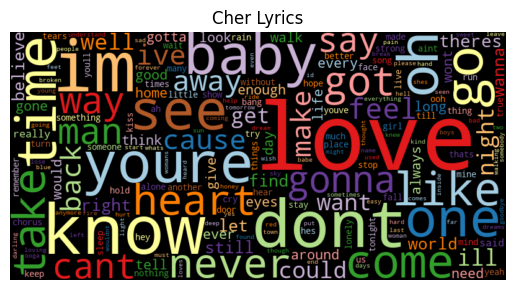

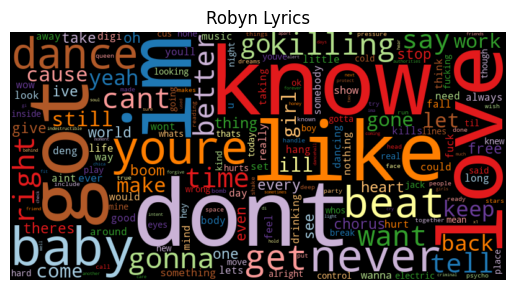

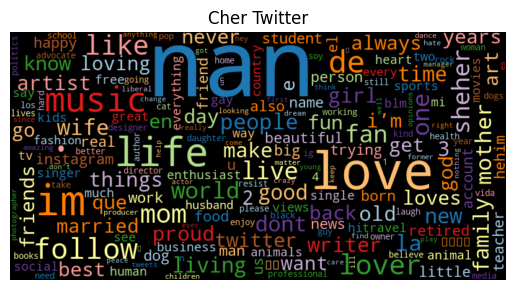

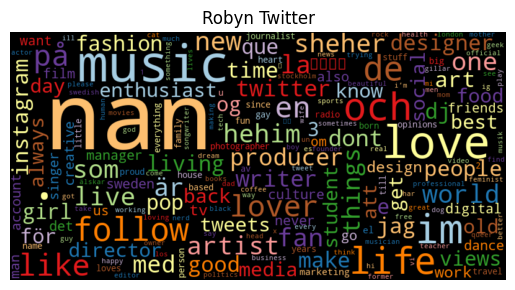

In [35]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    wc = WordCloud(width=800, height=400, 
                   background_color="black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq
    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token: freq for (token, freq) in counter.items() if token not in stopwords}
    wc.generate_from_frequencies(counter)
    plt.title(title)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Frequency counters
cher_lyrics_freq = Counter(cher_lyrics_tokens)
robyn_lyrics_freq = Counter(robyn_lyrics_tokens)
cher_twitter_freq = Counter(cher_twitter_tokens)
robyn_twitter_freq = Counter(robyn_twitter_tokens)

# Plot wordclouds
wordcloud(cher_lyrics_freq, title="Cher Lyrics")
wordcloud(robyn_lyrics_freq, title="Robyn Lyrics")
wordcloud(cher_twitter_freq, title="Cher Twitter")
wordcloud(robyn_twitter_freq, title="Robyn Twitter")


Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: Lyrics Wordclouds:

Both Cher and Robyn use emotional, conversational words like love, know, baby, don't, and you're.

Robyn emphasizes movement/dance-related terms like dance, beat, and go more than Cher, reflecting her dance-pop style.

Twitter Wordclouds:

The presence of 'nan' as a top word in both suggests missing or bad data.

Words like music, life, follow, artist, and love are common for both, showing shared fan and self-descriptions.

Robyn’s fans use more Swedish terms (nätet, jag, och), while Cher’s fans use more English family roles (wife, mom, teacher), hinting at demographic and cultural differences.